In [1]:
cd ../analysis/

/srv/data/home/jlee782/final_segmentation/analysis


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from withClustAnalysis import *
from PixelEM import * 

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [7]:
# Pick best clusters for each object sample based on MV
best_clust_df = best_worker_picking()

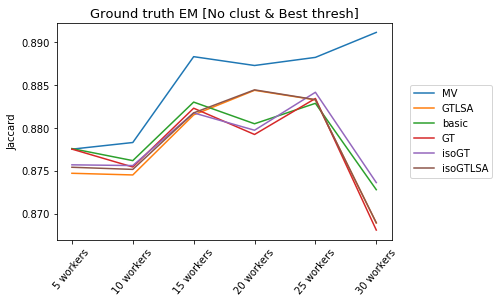

In [8]:
gt=""
MV = pd.read_csv("pixel_em/all_MV_PRJ_table.csv") 
MV = MV[MV["clust"]==-1]
MV_noClust = MV.groupby("num_workers").mean()["MV_jaccard"]
plt.plot(MV_noClust,label="MV")

for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
    data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
    data = data[data["clust"]==-1]
    plt.plot(data.groupby("num_workers").mean()["EM_jaccard"],label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM [No clust & Best thresh]",fontsize=13)

In [9]:
data.groupby(["num_workers","sample_num"]).count()["EM_jaccard"]

num_workers  sample_num
5            0             44
             1             44
             2             44
             3             44
             4             44
             5             44
             6             44
             7             44
             8             44
             9             44
10           0             44
             1             44
             2             44
             3             24
             4             23
             5             20
             6             23
             7             21
15           0             44
             1             44
             2             12
             3             11
             4             12
             5             12
20           0             30
             1             30
             2              6
             3              7
25           0             24
             1             22
30           0             13
Name: EM_jaccard, dtype: int64

In [10]:
clustObj=clust_df.objid.unique()

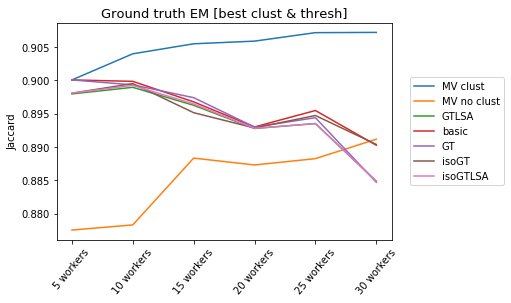

In [11]:
gt=""
MV = pd.read_csv("pixel_em/all_MV_PRJ_table.csv") 
# now need to filter based on best cluster
MV = filter_best_clust(MV,best_clust_df)
# select only the best cluster if clustered object -1 if not clustered
MV = MV[((MV["clust"]==-1) &(MV["objid"].isin(noClust_obj)))| ((MV["clust"]!=-1) & MV["objid"].isin(clustObj))]

#MV[(MV["num_workers"]==5)&(MV["sample_num"]==9)].sort("objid")
plt.plot(MV.groupby("num_workers").mean()["MV_jaccard"],label="MV clust")
plt.plot(MV_noClust,label="MV no clust")

for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
    # we only ran on the best clusters, so the results should only be on the best clusters if not -1
    data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
    data = data[((data["clust"]==-1) &(data["objid"].isin(noClust_obj)))| ((data["clust"]!=-1) & data["objid"].isin(clustObj))]
    plt.plot(data.groupby("num_workers").mean()["EM_jaccard"],label=algo)
    assert len(data.objid.unique())==len(object_lst)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM [best clust & thresh]",fontsize=13)

In [12]:
data.groupby(["num_workers","sample_num"]).count()["EM_jaccard"]

num_workers  sample_num
5            0             44
             1             44
             2             44
             3             44
             4             44
             5             44
             6             44
             7             44
             8             44
             9             44
10           0             44
             1             44
             2             44
             3             14
             4             13
             5             12
             6             13
             7             12
15           0             30
             1             26
             2              7
             3              6
             4              7
             5              7
20           0             14
             1             14
             2              4
             3              4
25           0             14
             1             12
30           0              8
Name: EM_jaccard, dtype: int64

In [14]:
algo="isoGTLSA"
data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
data[data["num_workers"]==30]

,num_workers,sample_num,objid,thresh,clust,EM_precision,EM_recall,EM_jaccard,EM_FPR%,EM_FNR%
1079,30,0,1,best,-1,0.987981,0.979453,0.967920,0.111026,2.054690
1080,30,0,2,best,-1,0.962261,0.984082,0.947513,0.085512,1.591831
1081,30,0,3,best,-1,0.963536,0.915966,0.885279,0.043508,8.403361
1082,30,0,4,best,-1,0.950045,0.950909,0.905628,0.054294,4.909091
1083,30,0,5,best,-1,0.963981,0.892319,0.863528,0.044532,10.768091
1084,30,0,6,best,-1,0.922039,0.879828,0.818908,0.016966,12.017167
1085,30,0,7,best,-1,0.883235,0.563737,0.524638,0.110669,43.626251
1086,30,0,8,best,-1,0.961694,0.893504,0.862797,0.324705,10.649623
1087,30,0,9,best,-1,0.979313,0.947918,0.929310,0.062992,5.208222
1088,30,0,10,best,-1,0.976290,0.978837,0.956109,0.137814,2.116308


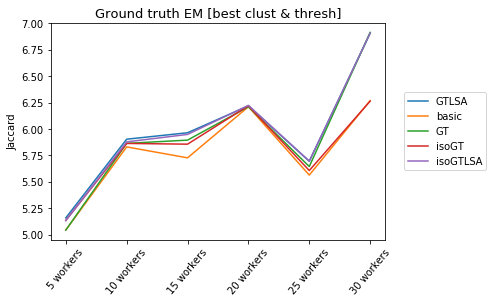

In [19]:
# gt=""
# MV = pd.read_csv("pixel_em/all_MV_PRJ_table.csv") 
# # now need to filter based on best cluster
# MV = filter_best_clust(MV,best_clust_df)
# # select only the best cluster if clustered object -1 if not clustered
# MV = MV[((MV["clust"]==-1) &(MV["objid"].isin(noClust_obj)))| ((MV["clust"]!=-1) & MV["objid"].isin(clustObj))]

# #MV[(MV["num_workers"]==5)&(MV["sample_num"]==9)].sort("objid")
# plt.plot(MV.groupby("num_workers").mean()["MV_jaccard"],label="MV clust")
# plt.plot(MV_noClust,label="MV no clust")

for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
    # we only ran on the best clusters, so the results should only be on the best clusters if not -1
    data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
    data = data[((data["clust"]==-1) &(data["objid"].isin(noClust_obj)))| ((data["clust"]!=-1) & data["objid"].isin(clustObj))]
    plt.plot(data.groupby("num_workers").mean()["EM_FNR%"],label=algo)
    assert len(data.objid.unique())==len(object_lst)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM [best clust & thresh]",fontsize=13)

## TPR, FNR 

In [85]:
def TFPNR(result,gt):    
    # True False Positive Negative Rates
    # as defined in https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Definitions
    intersection = len(np.where(((result==1)|(gt==1))&(result==gt))[0])
    gt_area = float(len(np.where(gt==1)[0]))
    result_area = float(len(np.where(result==1)[0]))

    TP = intersection
    FP = result_area - intersection
    FN = gt_area - intersection
    TN = product(shape(result)) - (gt_area+result_area-intersection)

    #TPR = TP/float(TP+FN)
    FPR = FP/float(FP+TN)
    FNR = FN/float(TP+FN)
    #TNR = TN/float(TN+FP)
    #assert TPR+FNR==1 and TNR+FPR==1

    #return  TPR,TNR#,FNR,TNR,FPR
    return FPR*100,FNR*100

In [86]:
result = pkl.load(open("pixel_em/10workers_rand0/obj1/clust0/gt_est_mask_best_thresh.pkl"))
gt = get_gt_mask(1)
TFPNR(result,gt)

(0.09892675150169385, 2.0546898869538652)

In [87]:
result = pkl.load(open("pixel_em/10workers_rand0/obj5/gt_est_mask_best_thresh.pkl"))
gt = get_gt_mask(5)
TFPNR(result,gt)

(0.036945284693106734, 10.496418868856509)